In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

#See first
Refer to https://rahulaga.medium.com/time-series-forecasting-with-facebook-prophet-f0468ff6fa3b
and this notebook first https://github.com/rahulaga/ml-for-business/blob/main/timeseries/timeseries_request-rate.ipynb


In [23]:
request_data = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/sample-hourly-request-rate.csv')

In [24]:
request_data.tail()

,Time,Point
667,5/6/21 14:00,640.439444
668,5/6/21 15:00,697.596944
669,5/6/21 16:00,647.408889
670,5/6/21 17:00,695.330556
671,5/6/21 18:00,675.820588


In [25]:
#convert type to datetime
request_data['Time'] = pd.to_datetime(request_data["Time"])

#For AWS the time column must be called timestamp and value as value
#note creating copy as going to set orginal Time as index
request_data['timestamp'] = request_data['Time']
request_data.rename(columns={'Point': 'value'}, inplace=True)

#set index as time for the series
request_data = request_data.set_index('Time')

In [26]:
request_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2021-04-08 19:00:00 to 2021-05-06 18:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   value      672 non-null    float64       
 1   timestamp  672 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


Loading next set of 7day data (7*24 rows)
Comparing this with forecast.

In [27]:
request_data_future = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/test-hourly-request-rate.csv')
print(request_data_future.shape)
request_data_future.tail()

(168, 2)


,Time,Point
163,5/13/21 14:00,856.887222
164,5/13/21 15:00,717.899167
165,5/13/21 16:00,709.526389
166,5/13/21 17:00,737.645278
167,5/13/21 18:00,855.658056


In [28]:
request_data_future['ds'] = request_data_future['Time']
#convert type to datetime
request_data_future['ds'] = pd.to_datetime(request_data_future['ds'])

request_data_future = request_data_future.set_index('Time')
request_data_future.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 5/6/21 19:00 to 5/13/21 18:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Point   168 non-null    float64       
 1   ds      168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9+ KB


In [29]:
#compare forecast with 7day future (used below)
def compare_future(forecast, title):
  forecast_tail = forecast.tail(7*24)
  fig, ax = plt.subplots()
  fig.set_size_inches(15,4)
  if('yhat_lower' in forecast_tail.columns):
    ax.fill_between(forecast_tail.ds, forecast_tail['yhat_lower'], forecast_tail['yhat_upper'], alpha=0.2)
  line1 = plt.plot(forecast_tail.ds, forecast_tail['yhat'], c='blue', label='forecast')
  line2 = plt.plot(request_data_future.ds, request_data_future['Point'], c='red', label='observed')

  lines = line1+line2
  labels = [l.get_label() for l in lines]
  ax.legend(lines, labels, loc=0)

  plt.title(title)

#Medium
Refer to 

# AWS - Amazon Forecast

In [30]:
#save file to work with AWS
request_data['item_id'] = 'ts1'
request_data = request_data[['item_id', 'timestamp','value']]#must be in this order
request_data.to_csv("sample-hourly-request-rate-aws.csv", date_format='%Y-%m-%d %H:%M:%S', index=False)

In [31]:
# load AWS predicted results
aws_predictions = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/predictions-aws.csv')
print(aws_predictions.shape)
aws_predictions.rename(columns={'p10':'yhat_lower','p50':'yhat','p90':'yhat_upper','timestamp':'ds'}, inplace=True)

(168, 4)


In [32]:
aws_predictions['ds']=pd.to_datetime(aws_predictions['ds'])
aws_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          168 non-null    datetime64[ns]
 1   yhat_lower  168 non-null    float64       
 2   yhat        168 non-null    float64       
 3   yhat_upper  168 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 5.4 KB


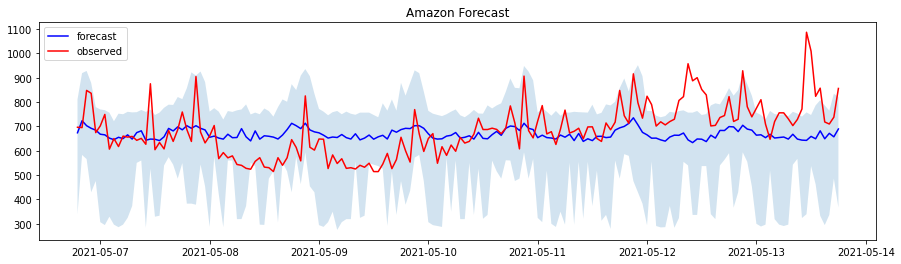

In [33]:
compare_future(aws_predictions,'Amazon Forecast')

# GCP - Vertex AI

In [34]:
# load gcp prediction results
gcp_predictions = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/batch-prediction-gcp-output.csv')
print(gcp_predictions.shape)
gcp_predictions.rename(columns={'predicted_Point': 'yhat','Time':'ds'}, inplace=True)

(168, 4)


In [35]:
gcp_predictions['ds']=pd.to_datetime(gcp_predictions['ds'])
gcp_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Point   0 non-null      float64       
 1   ds      168 non-null    datetime64[ns]
 2   ts_id   168 non-null    int64         
 3   yhat    168 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.4 KB


In [36]:
gcp_predictions.sort_values('ds', inplace=True)
gcp_predictions.tail()

,Point,ds,ts_id,yhat
118,NaN,2021-05-13 14:00:00,1,572.350525
59,NaN,2021-05-13 15:00:00,1,572.644226
61,NaN,2021-05-13 16:00:00,1,571.257751
42,NaN,2021-05-13 17:00:00,1,566.577393
101,NaN,2021-05-13 18:00:00,1,556.856506


In [37]:
gcp_predictions['yhat'].describe()

count    168.000000
mean     493.051054
std       73.255449
min      391.175629
25%      415.354774
50%      518.141327
75%      572.618774
max      577.865479
Name: yhat, dtype: float64

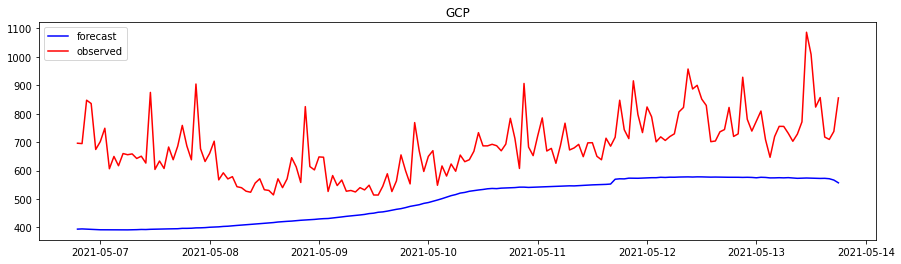

In [38]:
compare_future(gcp_predictions,'GCP')

# Azure AutoML

In [39]:
# load azure prediction results
azure_predictions = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/predictions-azure.csv')
print(azure_predictions.shape)
azure_predictions.rename(columns={'Point_predicted': 'yhat','Time':'ds'}, inplace=True)

(168, 3)


In [40]:
azure_predictions['ds']=pd.to_datetime(gcp_predictions['ds'])
azure_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Point_orig  168 non-null    float64       
 1   yhat        168 non-null    float64       
 2   Time_orig   168 non-null    object        
 3   ds          168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 5.4+ KB


In [41]:
azure_predictions.sort_values('ds', inplace=True)
azure_predictions.tail()

,Point_orig,yhat,Time_orig,ds
118,717.167778,696.612368,2021-05-11 17:00:00,2021-05-13 14:00:00
59,527.286111,627.660467,2021-05-09 06:00:00,2021-05-13 15:00:00
61,524.647222,629.723279,2021-05-09 08:00:00,2021-05-13 16:00:00
42,530.080556,616.834248,2021-05-08 13:00:00,2021-05-13 17:00:00
101,721.730278,680.650842,2021-05-11 00:00:00,2021-05-13 18:00:00


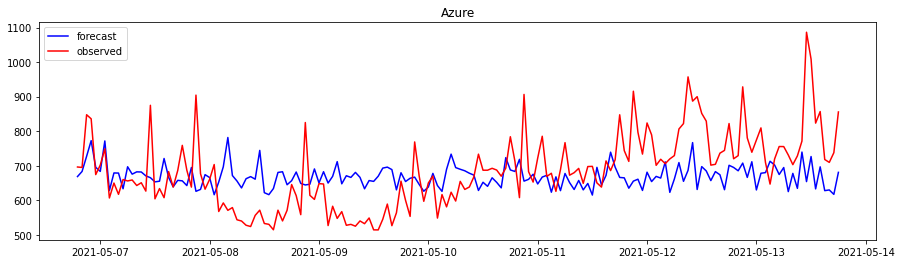

In [42]:
compare_future(azure_predictions,'Azure')